In [ ]:
# THINGS TO DO

# (1) K-Fold Cross Validation. Repeat M times and average MSE over all repetitions and folds. Choose alpha that minimises this average.

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, Lasso, Ridge, RidgeCV, LinearRegression
from BayesianLasso import BayesianLasso

In [2]:
"""

In this notebook, we apply the PulseCV and PulseMML BLasso methods to the dataset. We also calculate OLS estimates and 
Lasso estimates with lambda chosen by cross-validation. 

Finally, we treat the dataset from a ML perspective & use the data/feature engineering to try and optimise predictions.

"""

print(" ")

In [3]:
# Input dataset

dataset = pd.read_csv("Data/efron_diabetesData.txt",sep="\t")
dataset.shape

(442, 11)

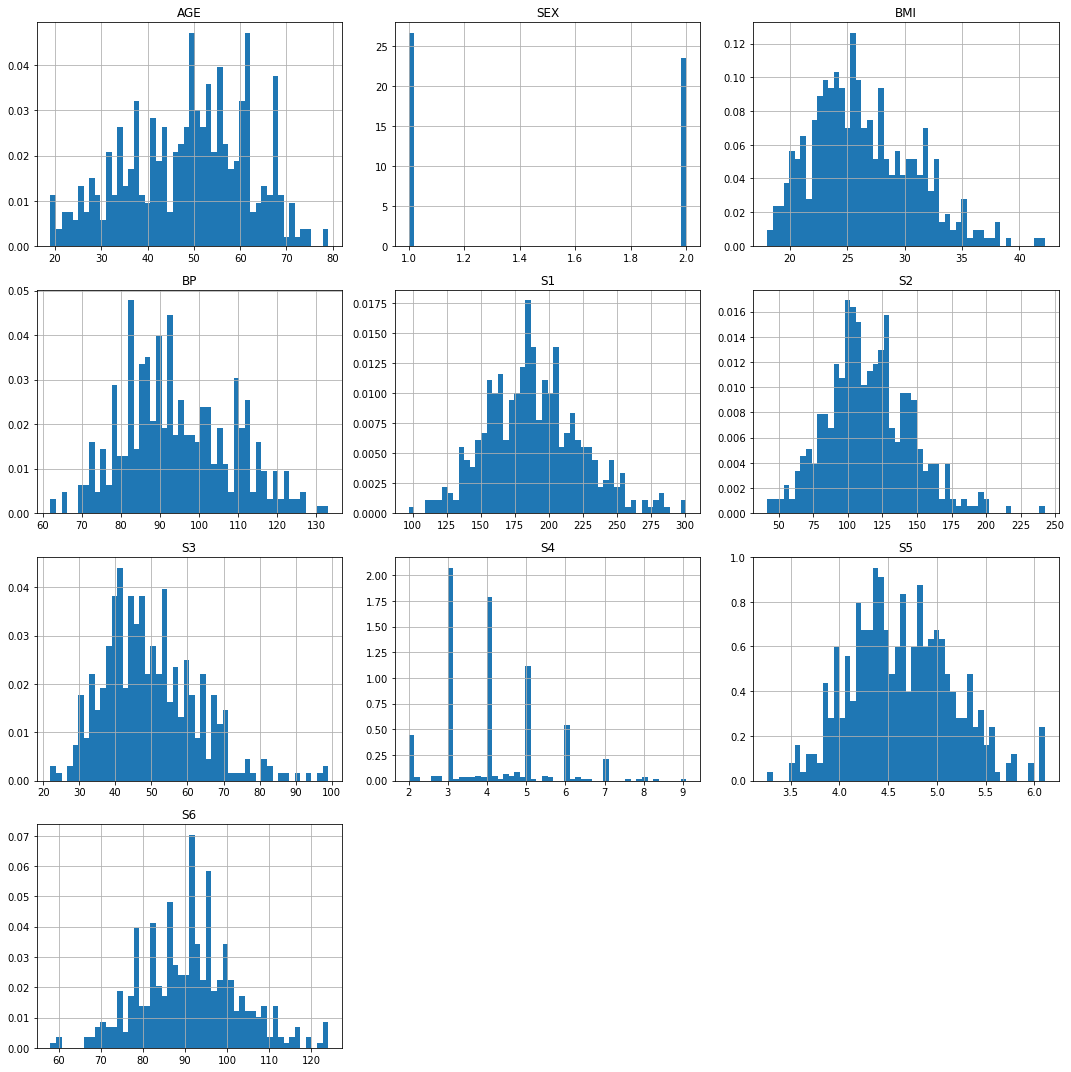

In [4]:
# Visualise design matrix (but NOT the response) to decide on how to split training/validation/test sets.
# Want the training set to fairly represent the population.

axFull = dataset.iloc[:,:-1].hist(bins=50, figsize=(15,15),density=True)

plt.tight_layout()
plt.show()

# Stratify SEX

In [5]:
# Shuffle dataset
# Split into training, validation and test sets
# DO NOT LOOK AT THE TEST SET (X_test,y_test)

train, rest = train_test_split(dataset,test_size=0.3,random_state=42,stratify=dataset["SEX"]) # Re-running this line of code alone will produce a different shuffle. Run previous block first.
valid, test = train_test_split(rest, test_size=0.5,random_state=142) # Re-running this line of code alone will produce a different shuffle. Run previous block first.

X_training = train.iloc[:,:-1]
X_valid = valid.iloc[:,:-1]
X_test = test.iloc[:,:-1]

y_training = train.iloc[:,-1]
y_valid = valid.iloc[:,-1]
y_test = test.iloc[:,-1]

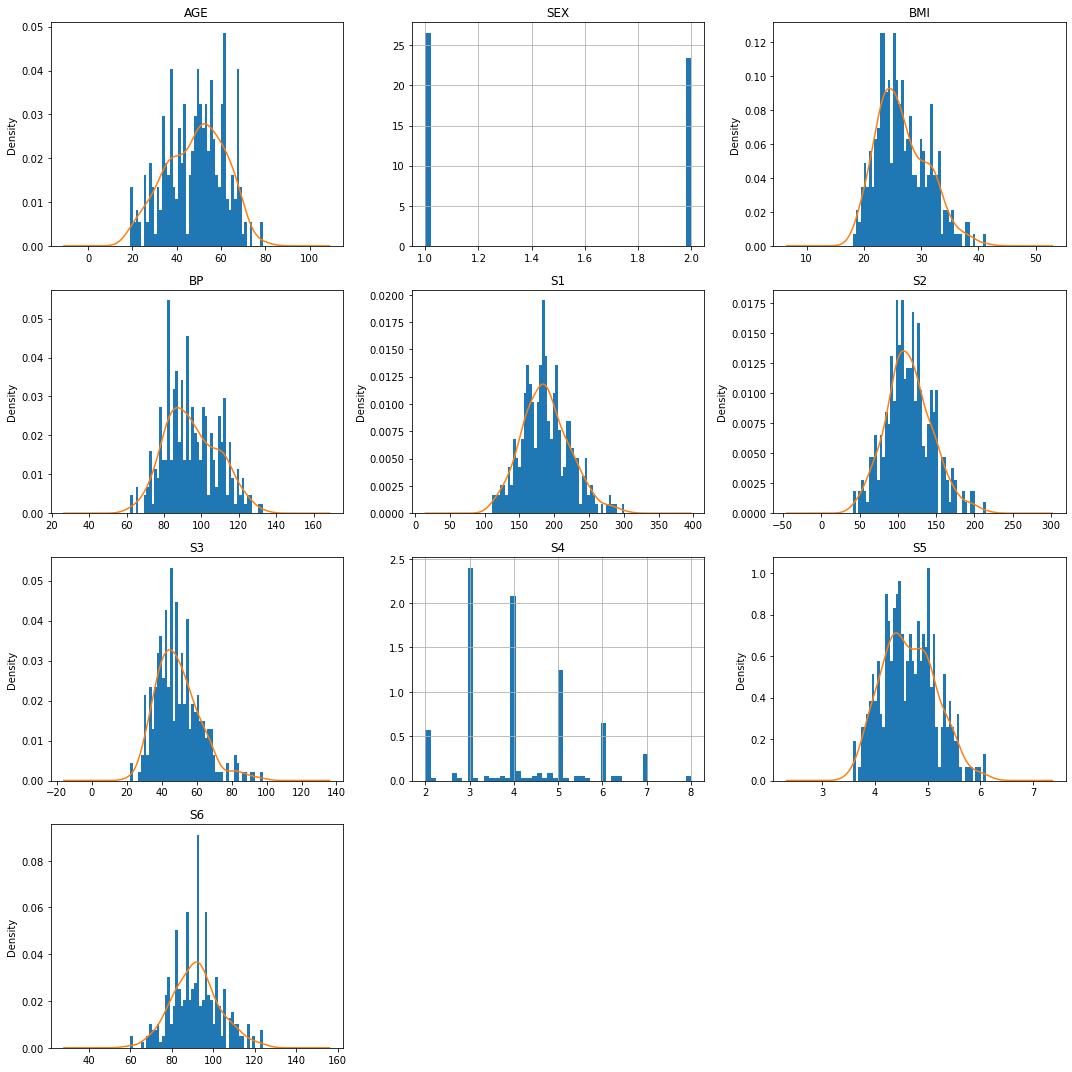

In [6]:
# Need to standardise the training set. Visualise the data.

"""Histograms with superimposed KDEs"""

ax = X_training.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_training.columns[3*row + col]=="SEX") or (X_training.columns[3*row + col]== "S4")):
            pass
        else:
            X_training[X_training.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        
X_training["S6"].plot(kind="kde",ax=ax[3][0])

plt.tight_layout()
plt.show()

# Normalise Sex instead of standardising it. Further suspicions on S4; this needs to be cleaned up, but for now standardise it.

In [7]:
# Create a Pipeline for easy processing of validation and test sets later

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

num_attribs = list(X_training.columns)
num_attribs.remove("SEX")
cat_attribs = ["SEX"]
    
num_pipeline = Pipeline([
    ("standardiser", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("normaliser", MinMaxScaler()),
])

processingPipeline = ColumnTransformer([
    ("numeric",num_pipeline,num_attribs),
    ("categoric",cat_pipeline,cat_attribs),
])

X_trainNP = processingPipeline.fit_transform(X_training)
X_trainNP

array([[-1.47961859,  1.88013219,  0.2463809 , ..., -1.19398793,
        -0.05746926,  0.        ],
       [ 0.73092862, -0.69378785,  0.08146959, ...,  0.50859196,
        -0.84476978,  1.        ],
       [-0.41245787,  1.72208447, -0.76785909, ...,  1.74099757,
         1.07974261,  0.        ],
       ...,
       [-1.09848976, -0.26480118, -0.13086258, ..., -0.4049008 ,
        -0.31990277,  0.        ],
       [-2.01319895, -0.82925733, -1.54641038, ..., -1.61755947,
        -0.05746926,  0.        ],
       [-0.03132904,  1.06731534, -1.38149906, ...,  1.8178131 ,
         0.99226478,  0.        ]])

In [8]:
# Print the preprocessed training set

X_train = pd.DataFrame(X_trainNP, columns = num_attribs + cat_attribs) # Pandas Dataframe
y_train = y_training - np.mean(y_training) # Pandas Dataframe
X_train, y_train

(          AGE       BMI        BP        S1        S2        S3        S4  \
 0   -1.479619  1.880132  0.246381  0.468138  0.919718  0.050514  0.014168   
 1    0.730929 -0.693788  0.081470  2.003627  1.854033  0.758217 -0.048937   
 2   -0.412458  1.722084 -0.767859  1.974656  1.906671 -1.286258  3.106341   
 3    0.044897 -1.280822 -0.909414 -1.994439 -0.962071 -2.072594  0.739882   
 4   -1.098490 -0.445427  1.638572  1.916713  2.288292 -0.814456  2.317521   
 ..        ...       ...       ...       ...       ...       ...       ...   
 304 -1.250941 -0.287379 -0.319838 -1.009408 -0.468595 -1.207624  0.345472   
 305 -1.174716 -1.325979 -0.767859 -1.820610 -1.462127 -0.264021 -0.837757   
 306 -1.098490 -0.264801 -0.130863  0.873739  0.965776  0.600949 -0.048937   
 307 -2.013199 -0.829257 -1.546410 -0.777636 -0.554131  0.365048 -0.837757   
 308 -0.031329  1.067315 -1.381499  1.569055  1.215804 -0.893090  1.820565   
 
            S5        S6  SEX  
 0   -1.193988 -0.057469  0.0 

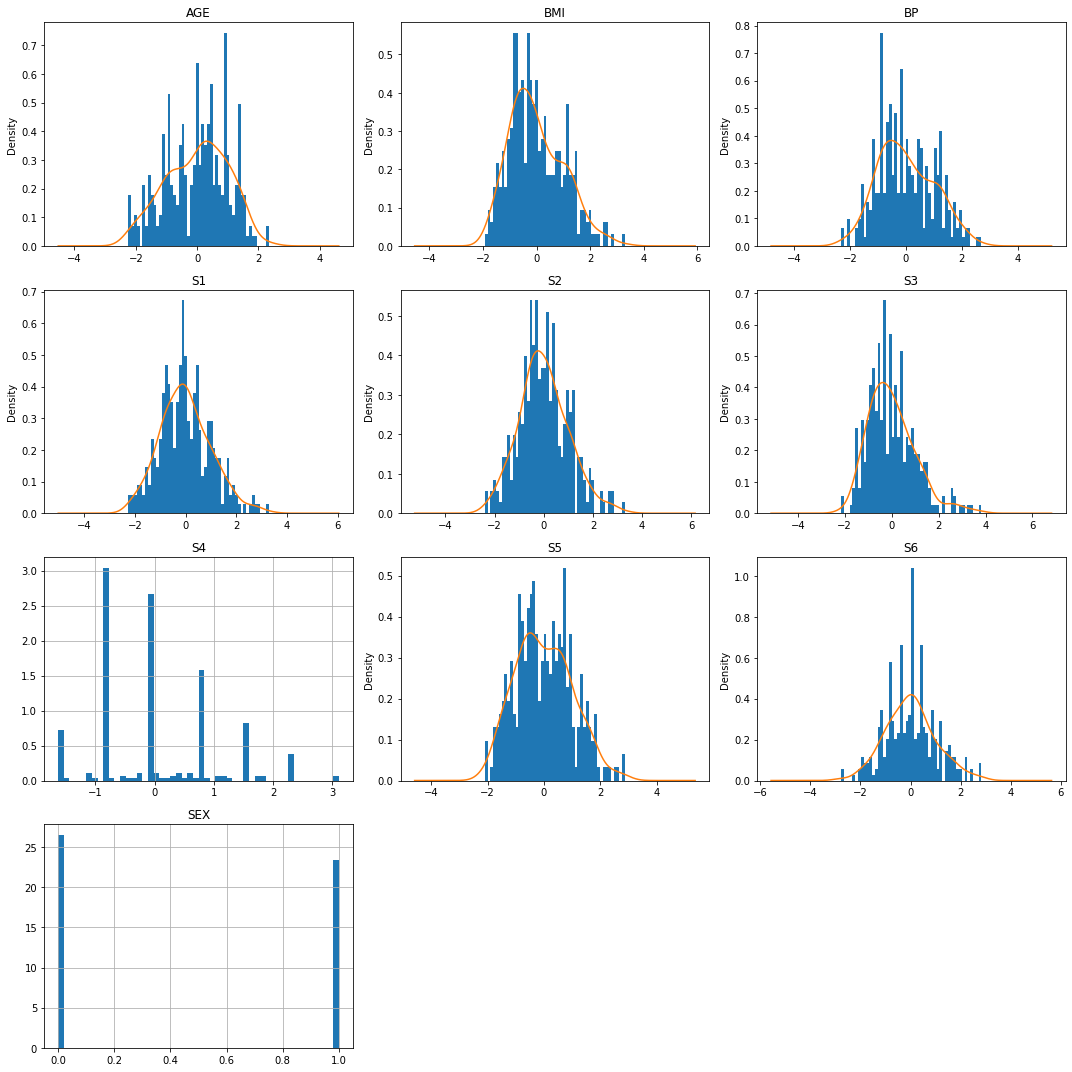

In [9]:
# See plots now

"""Histograms with superimposed KDEs"""

ax = X_train.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_train.columns[3*row + col]=="SEX") or (X_train.columns[3*row + col]== "S4")):
            pass
        else:
            X_train[X_train.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        

plt.tight_layout()
plt.show()

In [10]:
""" 
Having processed the dataset, create a linear regression model and determine OLS and Lasso estimates.
For the Lasso estimates, choose lambda by cross-validation.
"""
print(" ")

In [11]:
# Now create Linear Regression Model

linearModel = LinearRegression(fit_intercept=False)
linearModel.fit(X_train,y_train)
print(linearModel.coef_)

[ -1.0751097   24.18358663  18.11600629 -43.71163024  28.84432815
   6.65616813   7.68959414  42.09440482  -1.33260481 -10.99915842]


In [12]:
%%time
# Now create a Lasso Regression Model with lambda chosen by cross-validation

# Repeat 15-fold cross validation 25 times.
# For each repetition of CV, each fold and each alpha, compute the RMSE and store it.

alphaRange = np.linspace(0.0005,20,1000)
numFolds = 15
numCV = 25
CVresultsRMSE = np.zeros((numCV,numFolds,len(alphaRange)))

for cvidx in range(numCV):
    kf = KFold(n_splits=numFolds,shuffle=True,random_state=cvidx+1)
    for foldnum, (train_idx, test_idx) in enumerate(kf.split(X_train.values)):
        for alphaidx in range(len(alphaRange)):
            lassoModel_i = Lasso(alpha=alphaRange[alphaidx],fit_intercept=False, max_iter=10000, tol=1e-10)
            lassoModel_i.fit(X_train.iloc[train_idx],y_train.iloc[train_idx])
            CVresultsRMSE[cvidx,foldnum,alphaidx] = np.sqrt(mean_squared_error(y_train.iloc[test_idx],lassoModel_i.predict(X_train.iloc[test_idx])))


Wall time: 56min 19s


In [13]:
# We have a 3D array CVresultsRMSE that contains RMSEs for each iteration of CV, each fold and each alpha
# Average over the different datasets and different folds and choose the alpha that minimises rmse
# We use this alpha to fit a Lasso
lassoModel = Lasso(alpha=alphaRange[np.argmin(np.mean(np.mean(CVresultsRMSE,axis=0),axis=0))],fit_intercept=False)
lassoModel.fit(X_train,y_train)
np.linalg.norm(lassoModel.coef_,1)/np.linalg.norm(linearModel.coef_,1)

0.49472845464036463

In [14]:
print("Smallest lambda tested in CV is:",min(alphaRange)*2*X_train.shape[0])
print("Largest lambda tested in CV is:",max(alphaRange)*2*X_train.shape[0])
print("Number of lambdas tested in CV is:", len(alphaRange))
print("Lambda chosen by cross-validation is:", alphaRange[np.argmin(np.mean(np.mean(CVresultsRMSE,axis=0),axis=0))]*2*X_train.shape[0])
print("Relative L1 Norm of Betas chosen by lambda_CV:", np.linalg.norm(lassoModel.coef_,1)/np.linalg.norm(linearModel.coef_,1))

Smallest lambda tested in CV is: 0.309
Largest lambda tested in CV is: 12360.0
Number of lambdas tested in CV is: 1000
Lambda chosen by cross-validation is: 705.5165945945946
Relative L1 Norm of Betas chosen by lambda_CV: 0.49472845464036463


In [15]:
""" 
Now assume a Bayesian setting and place iid Laplace priors on the Beta as in Park & Casella. 
Place a Pulse Prior centred at lambdaMML^2 on lambda^2.
"""
print(" ")

In [16]:
# Now find the Maximum Marginal Likelihood estimate for lambda

bayesianLasso = BayesianLasso(X_train.values,np.reshape(y_train.values,(-1,1)))
lambdasMML,lambdaMML = bayesianLasso.lambda_MML(gibbs_iter=7500,em_iter=30)

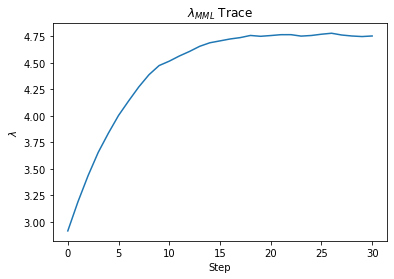

In [17]:
# Trace of the EM algorithm for lambdaMML

plt.title(fr"$\lambda_{{MML}}$ Trace")
plt.ylabel(r"$\lambda$")
plt.xlabel("Step")
plt.plot(lambdasMML)
plt.show()

In [18]:
# Run the Gibbs Sampler using the squared MML estimate for lambda as the mode of the Pulse Prior.

N = 50000
betaTracesPulseMML, sig2TracesPulseMML, tau2TracesPulseMML, lambdaTracesPulseMML = bayesianLasso.gibbs_gammaHPrior(r=1+(lambdaMML)**4,delta=lambdaMML**2,n_iter=N) 

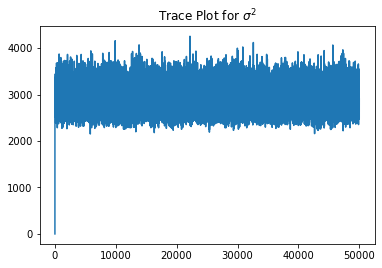

In [19]:
# Trace plot for Sigma^2

plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2TracesPulseMML)
plt.show()

# Use burn-in of 2500

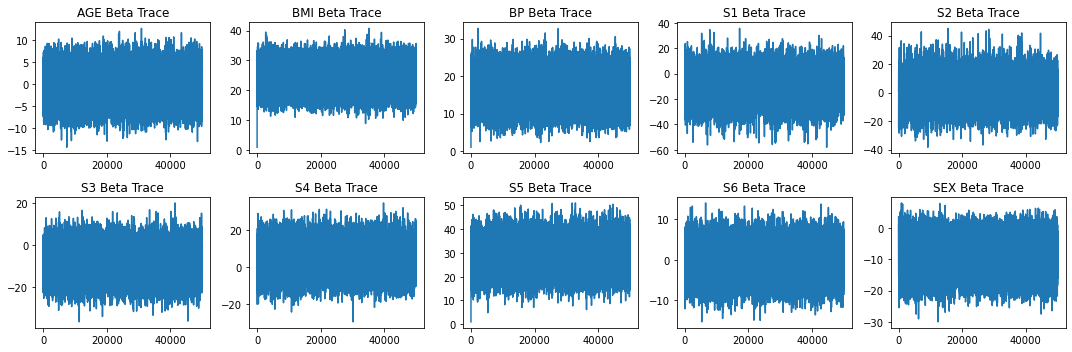

In [20]:
# Trace Plots for the Beta

figBetaTracesMML, axBetaTracesMML = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axBetaTracesMML[i-1][j-1].plot(betaTracesPulseMML[:,5*(i-1)+j-1])
        axBetaTracesMML[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta Trace")

plt.tight_layout()
plt.show()

# burn in 2500 suitable

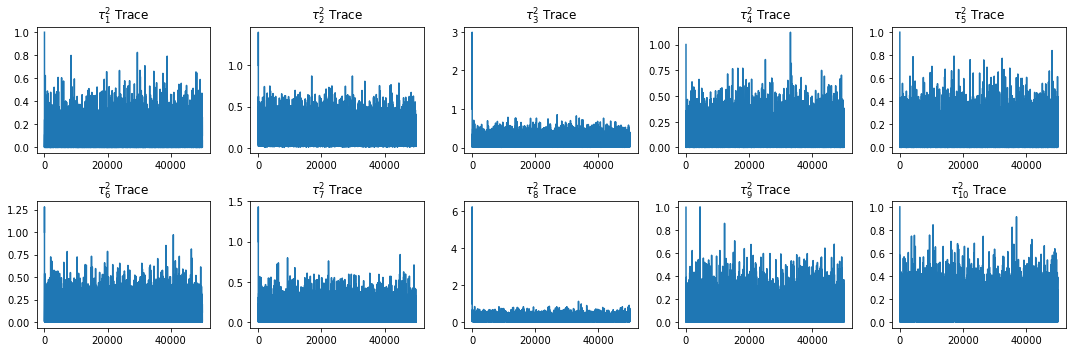

In [21]:
# Trace Plots for the Tau^2

figTau2TracesMML, axTau2TracesMML = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axTau2TracesMML[i-1][j-1].plot(tau2TracesPulseMML[:,5*(i-1)+j-1])
        axTau2TracesMML[i-1][j-1].title.set_text(fr"$\tau^{2}_{{{5*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()

# burn in 2500 suitable

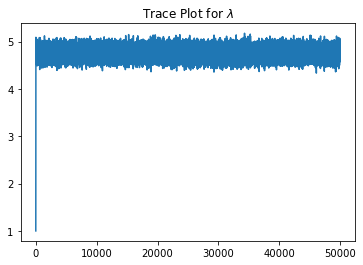

In [22]:
# Trace plot for Lambdas

plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambdaTracesPulseMML)
plt.show()

# Use burn-in of 2000

In [23]:
burned_BetaPulseMML = betaTracesPulseMML[2000:,:]
burned_Sig2PulseMML = sig2TracesPulseMML[2000:]
burned_Tau2PulseMML = tau2TracesPulseMML[2000:,:]
burned_LambdaPulseMML = lambdaTracesPulseMML[2000:]

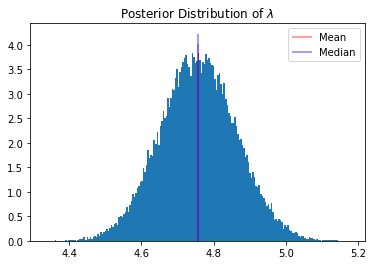

Mean: 4.757355688507924
Median: 4.757013400097383


In [24]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaPulseMML,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaPulseMML),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.5)
plt.vlines(np.median(burned_LambdaPulseMML),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.5)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaPulseMML)}")
print(f"Median: {np.median(burned_LambdaPulseMML)}")

# Mode roughly the MML estimate

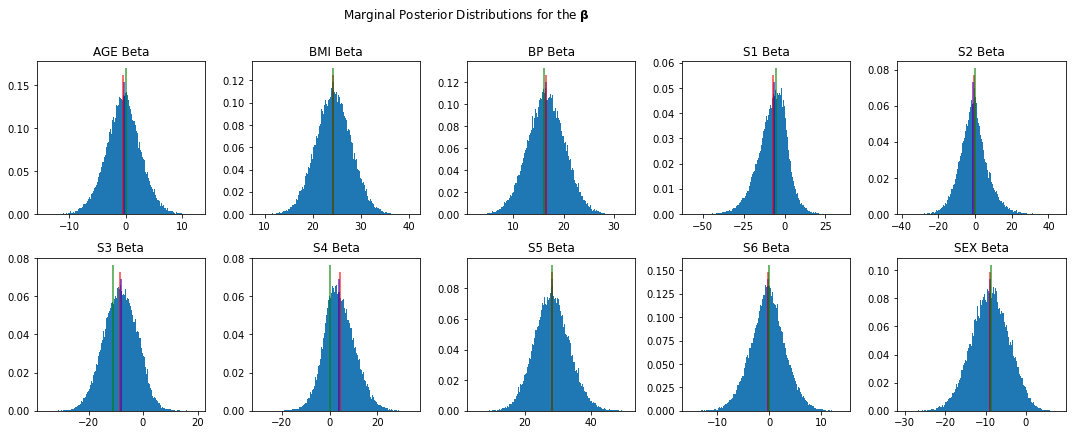

In [25]:
# Histograms for Beta with superimposed mean & median estimates, as well as approximate Modes via. frequentist Lasso.

sigmamedianMML = np.median(np.sqrt(burned_Sig2PulseMML))
lambdamedianMML = np.median(burned_LambdaPulseMML)

_,lassoModes = bayesianLasso.lasso(2*sigmamedianMML*lambdamedianMML,steps=1000)

figBetaHistMML, axBetaHistMML = plt.subplots(nrows=2,ncols=5,figsize=(15,6))

for i in range(1, 3):
    for j in range(1, 6):
        axBetaHistMML[i-1][j-1].hist(burned_BetaPulseMML[:,5*(i-1)+j-1],bins=200,density=True)
        axBetaHistMML[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta")
        axBetaHistMML[i-1][j-1].vlines(np.median(burned_BetaPulseMML,axis=0)[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.75)
        axBetaHistMML[i-1][j-1].vlines(np.mean(burned_BetaPulseMML,axis=0)[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.75)
        axBetaHistMML[i-1][j-1].vlines(lassoModes[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.75)

figBetaHistMML.suptitle(r"Marginal Posterior Distributions for the $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [26]:
""" 
Continue the Bayesian setting with iid Laplace priors on the Beta as in Park & Casella. 
Place a Pulse Prior centred at lambdaCV^2 on lambda^2.
"""
print(" ")

In [27]:
# Compute rescaled lambdaCV

lambdaCV = alphaRange[np.argmin(np.mean(np.mean(CVresultsRMSE,axis=0),axis=0))] * 2 * X_train.shape[0]

smLinearModel = sm.OLS(y_train.values,X_train.values).fit()
s2 = np.sum(smLinearModel.resid**2)/(X_train.shape[0]-X_train.shape[1])
print("OLS estimate for regression variances:", s2)
lam_rescaledCV = lambdaCV/(2*np.sqrt(s2))

print("Rescaled Lambda chosen by Cross-Validation:", lam_rescaledCV)

OLS estimate for regression variances: 2894.9750313157347
Rescaled Lambda chosen by Cross-Validation: 6.556239748914677


In [28]:
# Run the Gibbs Sampler using the rescaled CV estimate for lambda as nu in the defined Pulse Prior

betaTracesPulseCV, sig2TracesPulseCV, tau2TracesPulseCV, lambdaTracesPulseCV = bayesianLasso.gibbs_gammaHPrior(r = 1+(lam_rescaledCV**4), delta = lam_rescaledCV**2, n_iter=50000)

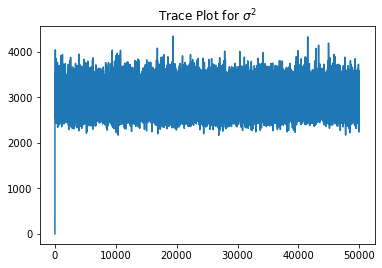

In [29]:
# Trace plot for Sigma^2

plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2TracesPulseCV)
plt.show()

# A burn in period of 5000 seems sufficient

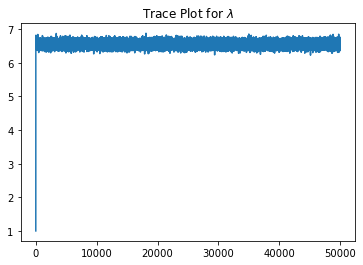

In [30]:
# Trace plot for Lambda

plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambdaTracesPulseCV)
plt.show()

# A burn in period of 5000 seems sufficient

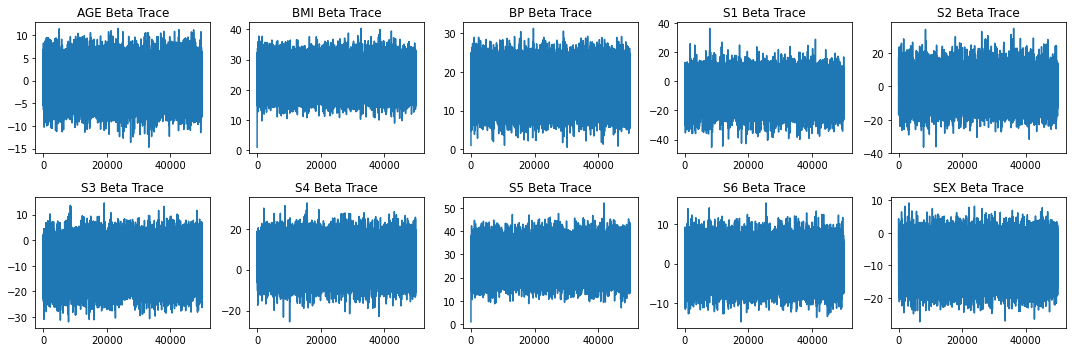

In [31]:
# Trace Plots for the Beta

figBetaTracesCV, axBetaTracesCV = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axBetaTracesCV[i-1][j-1].plot(betaTracesPulseCV[:,5*(i-1)+j-1])
        axBetaTracesCV[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta Trace")

plt.tight_layout()
plt.show()

# burn in 5000 suitable

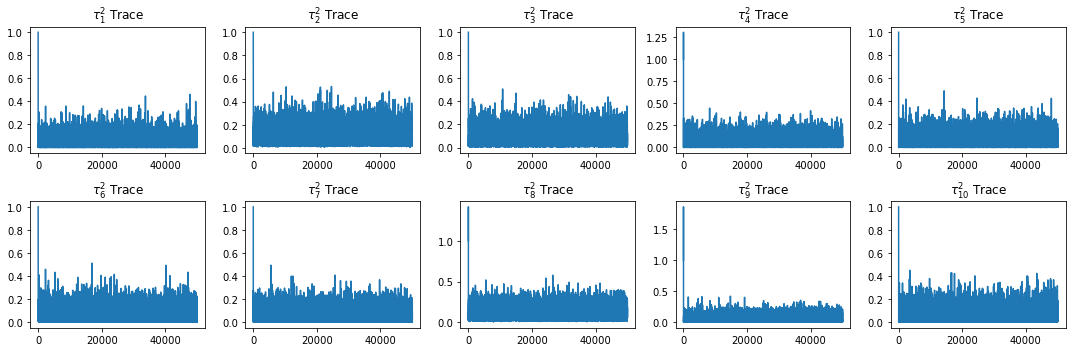

In [32]:
# Trace Plots for the Tau^2

figTau2TracesCV, axTau2TracesCV = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axTau2TracesCV[i-1][j-1].plot(tau2TracesPulseCV[:,5*(i-1)+j-1])
        axTau2TracesCV[i-1][j-1].title.set_text(fr"$\tau^{2}_{{{5*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()

# burn in 5000 suitable

In [33]:
burned_BetaPulseCV = betaTracesPulseCV[5000:,:]
burned_Sig2PulseCV = sig2TracesPulseCV[5000:]
burned_Tau2PulseCV = tau2TracesPulseCV[5000:,:]
burned_LambdaPulseCV = lambdaTracesPulseCV[5000:]

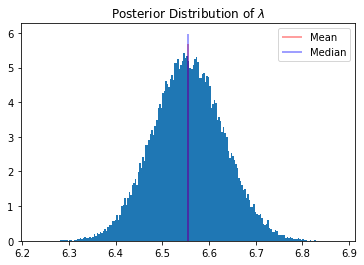

Mean: 6.555265470615005
Median: 6.554706376021714


In [34]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaPulseCV,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaPulseCV),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.5)
plt.vlines(np.median(burned_LambdaPulseCV),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.5)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaPulseCV)}")
print(f"Median: {np.median(burned_LambdaPulseCV)}")

# Mode appears to agree with the rescaled lambdaCV. Note that it's similar in size to (but slghtly larger than) lambdaMML.

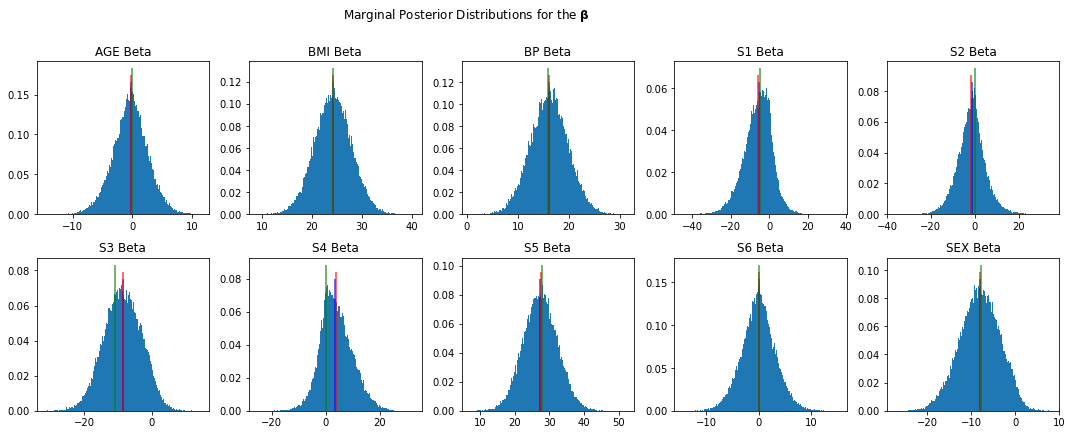

In [35]:
# Histograms for Beta in the PulseCV case.

sigmamedianCV = np.median(np.sqrt(burned_Sig2PulseCV))
lambdamedianCV = np.median(burned_LambdaPulseCV)

_,lassoModesCV = bayesianLasso.lasso(2*sigmamedianCV*lambdamedianCV,steps=1000)

figCV, axCV = plt.subplots(nrows=2,ncols=5,figsize=(15,6))

for i in range(1, 3):
    for j in range(1, 6):
        axCV[i-1][j-1].hist(burned_BetaPulseCV[:,5*(i-1)+j-1],bins=200,density=True)
        axCV[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta")
        axCV[i-1][j-1].vlines(np.median(burned_BetaPulseCV,axis=0)[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.75)
        axCV[i-1][j-1].vlines(np.mean(burned_BetaPulseCV,axis=0)[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.75)
        axCV[i-1][j-1].vlines(lassoModesCV[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.75)

figCV.suptitle(r"Marginal Posterior Distributions for the $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# Approximate modes very close to the actual modes.

In [36]:
""" 
Make 2 plots, each corresponding to one of the Bayesian models.
For each predictor, plot the OLS estimate, Lasso estimate and posterior median estimate. Superimpose 95% equitailed intervals.
"""

print(" ")

In [37]:
# Compile the posterior medians and equitailed intervals in one place

betaPosteriorMediansMML = np.median(burned_BetaPulseMML,axis=0)
betaPosteriorMediansCV = np.median(burned_BetaPulseCV,axis=0)
beta95EquitailedMML = np.quantile(burned_BetaPulseMML,[0.025,0.975],axis=0).T
beta95EquitailedCV = np.quantile(burned_BetaPulseCV,[0.025,0.975],axis=0).T

print(beta95EquitailedMML.shape,beta95EquitailedCV.shape)

(10, 2) (10, 2)


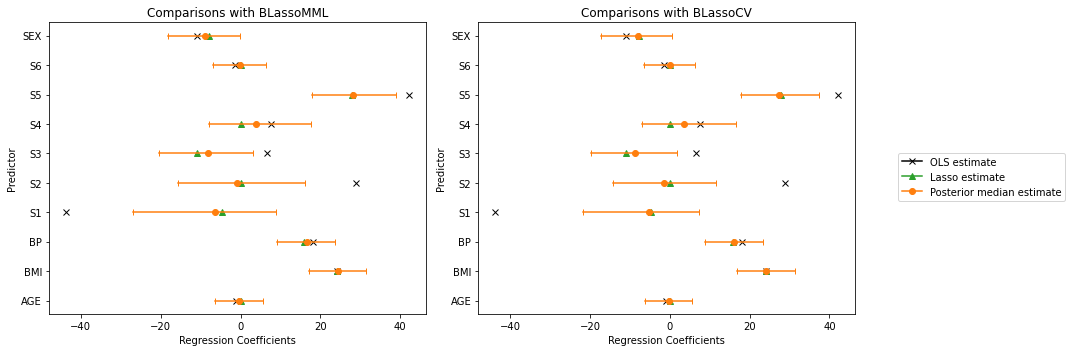

In [38]:
# We now have OLS, Lasso (CV) and two Bayesian Lasso estimates.
# Make two plots with x-axis coefficients and y-axis variable number.
# For each predictor, plot posterior median & equitailed intervals, OLS estimates, Lasso estimates with lambda chosen by CV

figResults, axResults = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axResults[0].set_xlabel("Regression Coefficients")
axResults[0].set_ylabel("Predictor")
axResults[0].set_yticks(np.linspace(1,11,11))
axResults[0].set_yticklabels(num_attribs + cat_attribs + [""])

axResults[1].set_xlabel("Regression Coefficients")
axResults[1].set_ylabel("Predictor")
axResults[1].set_yticks(np.linspace(1,11,11))
axResults[1].set_yticklabels(num_attribs + cat_attribs + [""])

for pred in range(1,11):
    # Plot OLS estimates
    axResults[0].plot(linearModel.coef_[pred-1],pred,marker="x",color="black",label="OLS estimate")
    axResults[1].plot(linearModel.coef_[pred-1],pred,marker="x",color="black",label="OLS estimate")
    # Plot Lasso estimates based on 10 fold cross-validation
    axResults[0].plot(lassoModel.coef_[pred-1],pred,marker="^",color="tab:green",label="Lasso estimate")
    axResults[1].plot(lassoModel.coef_[pred-1],pred,marker="^",color="tab:green",label="Lasso estimate")
    # Plot Posterior median estimates
    axResults[0].plot(betaPosteriorMediansMML[pred-1],pred,marker="o",color="tab:orange",label="Posterior median estimate")
    axResults[1].plot(betaPosteriorMediansCV[pred-1],pred,marker="o",color="tab:orange",label="Posterior median estimate")
    # Plot Equitailed Intervals
    axResults[0].plot(beta95EquitailedMML[pred-1],(pred,pred),marker="|",color="tab:orange")
    axResults[1].plot(beta95EquitailedCV[pred-1],(pred,pred),marker="|",color="tab:orange")
    # Set titles
    axResults[0].title.set_text("Comparisons with BLassoMML")
    axResults[1].title.set_text("Comparisons with BLassoCV")
    
    if pred == 10:
        handles, labels = axResults[1].get_legend_handles_labels()
        legdict = dict(zip(labels, handles))
        axResults[1].legend(legdict.values(),legdict.keys(),bbox_to_anchor=(1.1, 0.57))
        
plt.tight_layout()
plt.show()

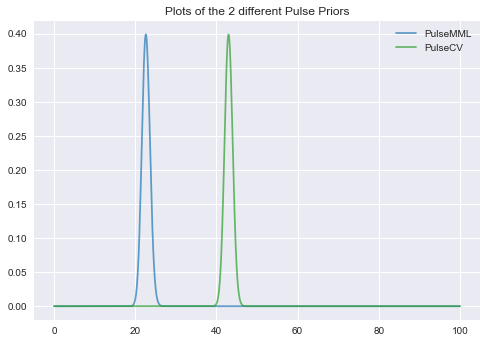

In [39]:
# BLassoMML seems to result in wider/less certain posterior distributions.
# In general the posterior median estimates are closer to the lasso estimates in the BLassoCV model.
# We finally plot the two different Gamma distributions used.

plt.style.use("seaborn")
domain = np.linspace(0,100,1000)
pulsemml = stats.gamma.pdf(domain,1+lambdaMML**4,scale=1/(lambdaMML**2))
pulsecv = stats.gamma.pdf(domain,1+lam_rescaledCV**4,scale=1/(lam_rescaledCV**2))

plt.title("Plots of the 2 different Pulse Priors")
plt.plot(domain,pulsemml,color="tab:blue",label="PulseMML",alpha=0.7)
plt.plot(domain,pulsecv,color="tab:green",label="PulseCV",alpha=0.7)

plt.legend()
plt.show()

# Not surprising because in this case, the PulseCV model places greater weight on larger lambda than PulseMML.
# The stricter the regularisation, the smaller the uncertainty, justifying the above observation.
# However, the results from both methods are similar.
# We expect the PulseCV to extract an extra ounce of prediction accuracy compared to PulseMML

In [40]:
"""
I now treat the validation set as a test set.
For each of the Bayesian models, I compute posterior predictive distributions by a Monte-Carlo Method.
"""

print(" ")

In [41]:
# First pre-process the dataset in the same way that the training set was preprocessed.

X_validPrep = processingPipeline.transform(X_valid)
y_validPrep = y_valid - np.mean(y_training) # KEY: SUBTRACT Y_TRAINING MEAN NOT Y_TRAIN MEAN

In [42]:
# (1) First consider the BLassoMML model. 

# ----------- Monte Carlo Method -------------
#    (a) Sample (beta,sig^2)^(i) ~ p(beta,sig^2|X_train,y_train)
#    (b) Sample y^(i) ~ p(y|x_test^T,beta,sig^2)

M = 5000

predictiveDistSamples = np.zeros((M,len(y_validPrep)))
jointPosteriorSamples = np.concatenate((burned_BetaPulseMML,np.reshape(burned_Sig2PulseMML,(-1,1))),axis=1)
rowindicies = np.random.choice([j for j in range(jointPosteriorSamples.shape[0])],size=(M,len(y_validPrep)))

for test in range(len(y_validPrep)):
    # Find posterior predictive distribution using the Monte Carlo Method
    for step in range(M):
        posteriorSample = jointPosteriorSamples[rowindicies[step,test],:]
        posteriorSampleBeta = np.reshape(posteriorSample[:burned_BetaPulseMML.shape[1]],(-1,1))
        posteriorSampleSig2 = posteriorSample[burned_BetaPulseMML.shape[1]:]
        
        xtestT = np.reshape(X_validPrep[test,:],(1,-1))
        xTbeta = np.matmul(xtestT,posteriorSampleBeta)
        predictivesample = np.random.normal(loc=xTbeta[0],scale=np.sqrt(posteriorSampleSig2[0]),size=1)
        predictiveDistSamples[step,test] = predictivesample
        

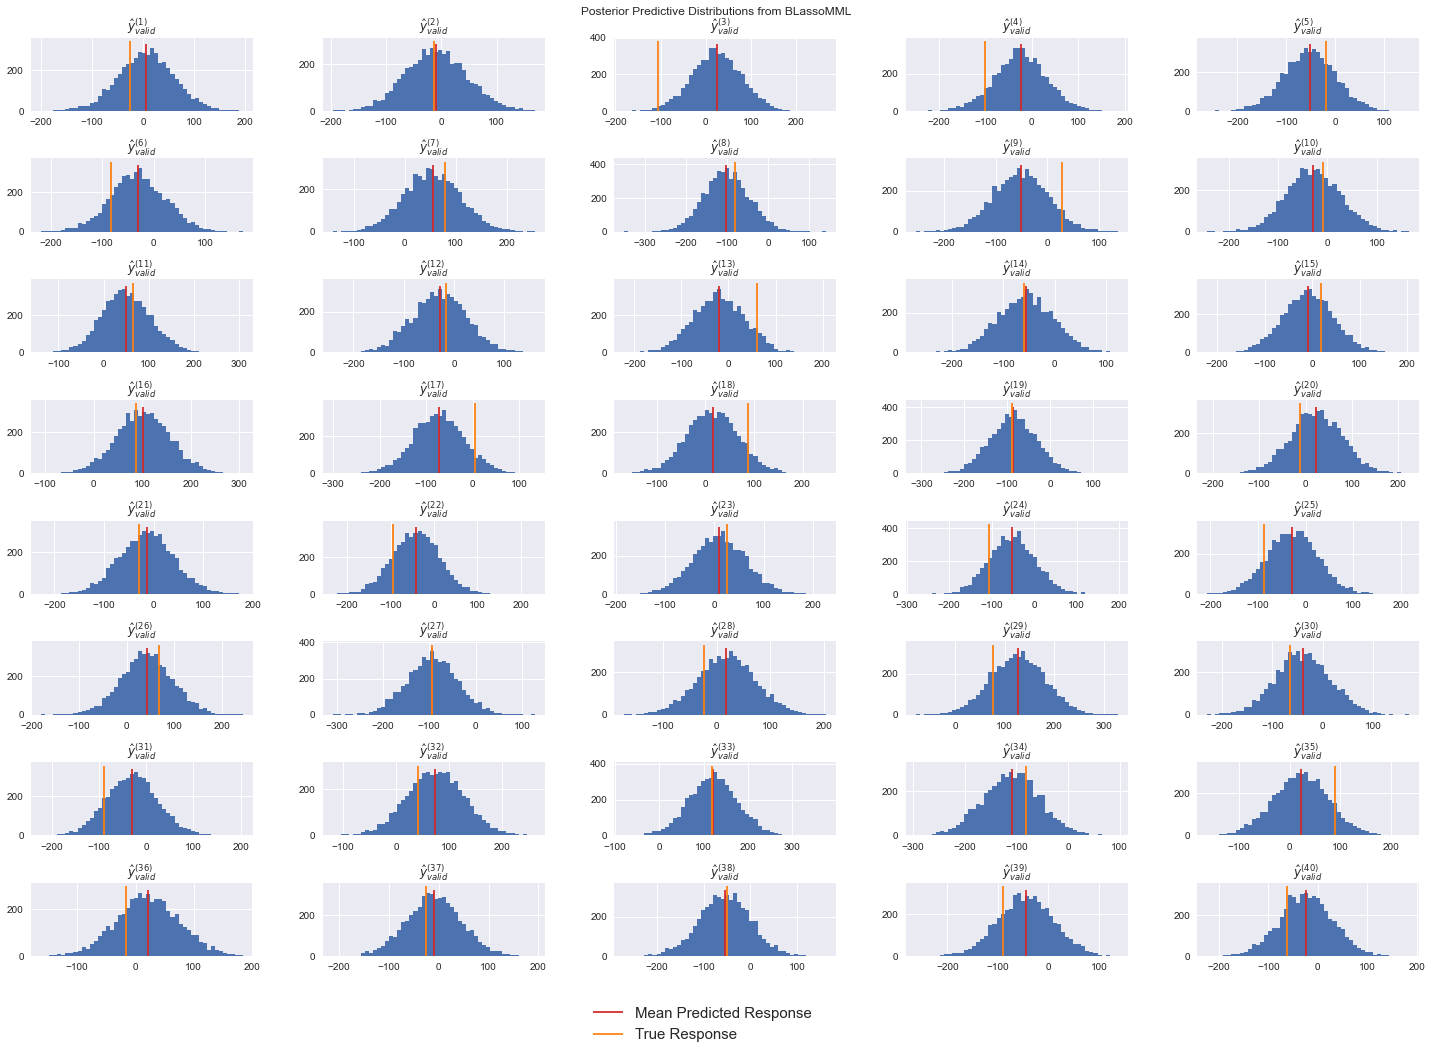

In [43]:
figPredMML, axPredMML = plt.subplots(nrows=8,ncols=5,figsize=(20,15))

for row in range(1,9):
    for col in range(1,6):
        axPredMML[row-1,col-1].hist(predictiveDistSamples[:,5*(row-1)+col-1],bins=50)
        axPredMML[row-1,col-1].vlines(np.mean(predictiveDistSamples[:,5*(row-1)+col-1]),0,axPredMML[row-1,col-1].get_ylim()[1],color="tab:red", label="Mean Predicted Response")
        axPredMML[row-1,col-1].vlines(y_validPrep.values[5*(row-1)+col-1],0,axPredMML[row-1,col-1].get_ylim()[1],color="tab:orange",label="True Response")
        axPredMML[row-1,col-1].title.set_text(fr"$\hat{{y}}_{{valid}}^{{({5*(row-1)+col})}}$")
        if ((row == 8) and (col == 3)):
            axPredMML[row-1,col-1].legend(bbox_to_anchor = (0.95,-0.5),fontsize=15)
plt.suptitle("Posterior Predictive Distributions from BLassoMML")
plt.tight_layout()
plt.show()


In [44]:
# (2) Now consider the BLassoCV model. 

# ----------- Monte Carlo Method -------------
#    (a) Sample (beta,sig^2)^(i) ~ p(beta,sig^2|X_train,y_train)
#    (b) Sample y^(i) ~ p(y|x_test^T,beta,sig^2)

M = 5000

predictiveDistSamplesCV = np.zeros((M,len(y_validPrep)))
jointPosteriorSamplesCV = np.concatenate((burned_BetaPulseCV,np.reshape(burned_Sig2PulseCV,(-1,1))),axis=1)
rowindiciesCV = np.random.choice([j for j in range(jointPosteriorSamplesCV.shape[0])],size=(M,len(y_validPrep)))

for test in range(len(y_validPrep)):
    # Find posterior predictive distribution using the Monte Carlo Method
    for step in range(M):
        posteriorSampleCV = jointPosteriorSamplesCV[rowindiciesCV[step,test],:]
        posteriorSampleBetaCV = np.reshape(posteriorSampleCV[:burned_BetaPulseCV.shape[1]],(-1,1))
        posteriorSampleSig2CV = posteriorSampleCV[burned_BetaPulseCV.shape[1]:]
        
        xtestTCV = np.reshape(X_validPrep[test,:],(1,-1))
        xTbetaCV = np.matmul(xtestTCV,posteriorSampleBetaCV)
        predictivesampleCV = np.random.normal(loc=xTbetaCV[0],scale=np.sqrt(posteriorSampleSig2CV[0]),size=1)
        predictiveDistSamplesCV[step,test] = predictivesampleCV
        

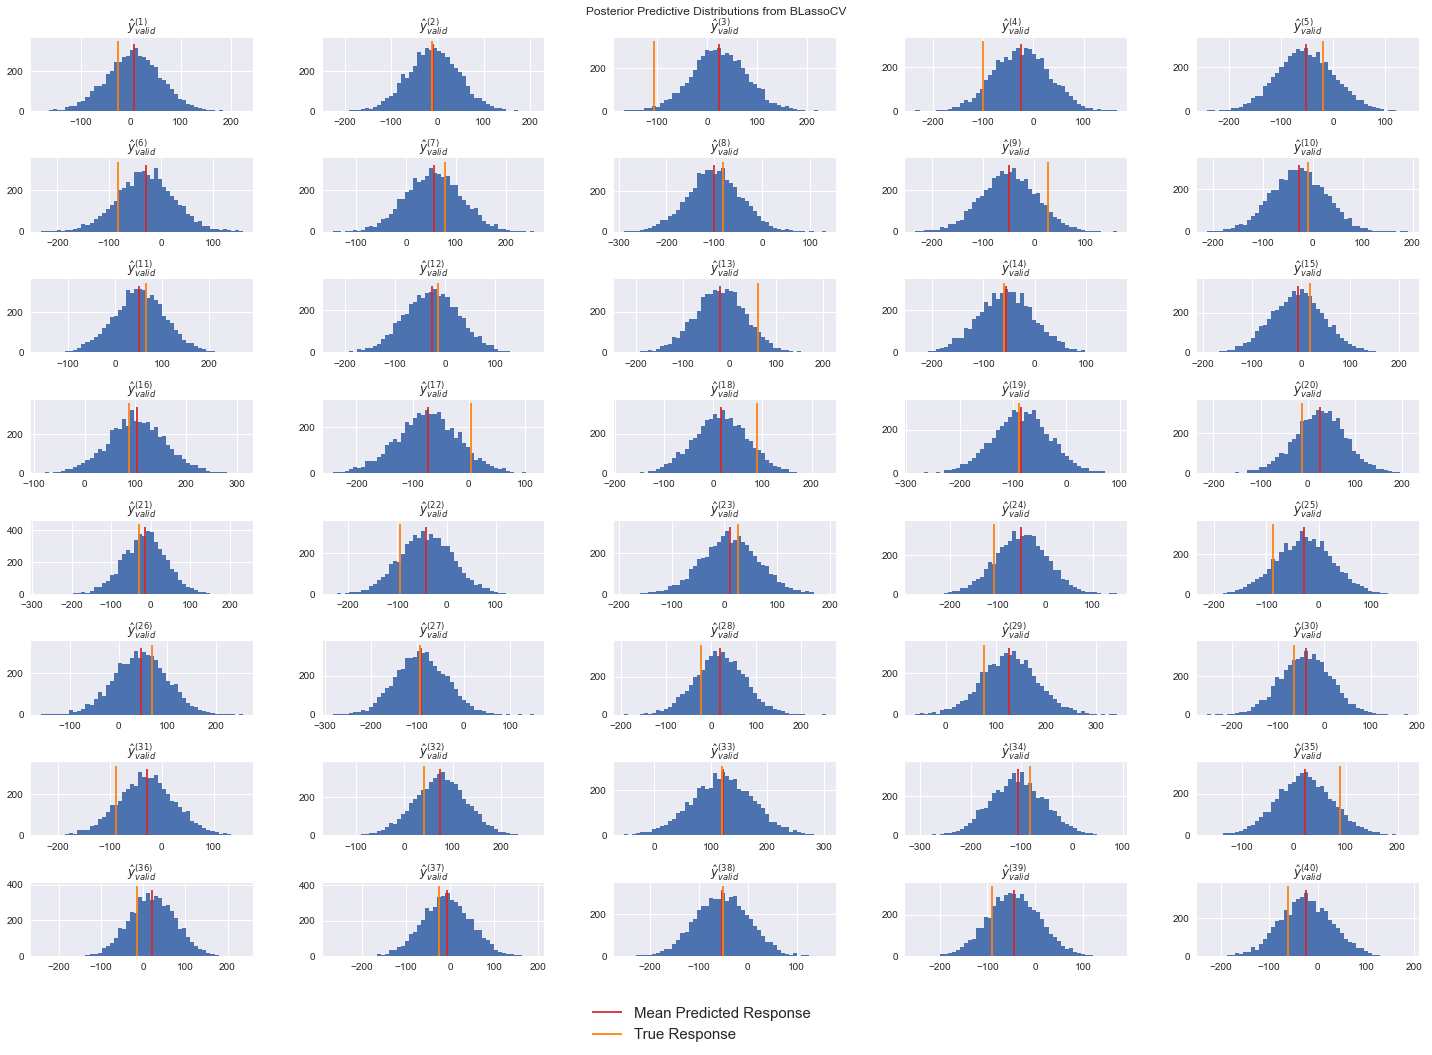

In [45]:
# Plot the Predictive distributions for BLassoCV

figPredCV, axPredCV = plt.subplots(nrows=8,ncols=5,figsize=(20,15))

for row in range(1,9):
    for col in range(1,6):
        axPredCV[row-1,col-1].hist(predictiveDistSamplesCV[:,5*(row-1)+col-1],bins=50)
        axPredCV[row-1,col-1].vlines(np.mean(predictiveDistSamplesCV[:,5*(row-1)+col-1]),0,axPredCV[row-1,col-1].get_ylim()[1],color="tab:red", label="Mean Predicted Response")
        axPredCV[row-1,col-1].vlines(y_validPrep.values[5*(row-1)+col-1],0,axPredCV[row-1,col-1].get_ylim()[1],color="tab:orange", label="True Response")
        axPredCV[row-1,col-1].title.set_text(fr"$\hat{{y}}_{{valid}}^{{({5*(row-1)+col})}}$")
        if ((row == 8) and (col == 3)):
            axPredCV[row-1,col-1].legend(bbox_to_anchor = (0.95,-0.5),fontsize=15)
        
plt.suptitle("Posterior Predictive Distributions from BLassoCV")
plt.tight_layout()
plt.show()


In [46]:
# Return the RMSEs

print("Prediction RMSE for BLassoMML:", np.sqrt(np.sum((np.mean(predictiveDistSamples,axis=0)-y_validPrep)**2)))
print("Prediction RMSE for BLassoCV:", np.sqrt(np.sum((np.mean(predictiveDistSamplesCV,axis=0)-y_validPrep)**2)))

Prediction RMSE for BLassoMML: 437.70644158986033
Prediction RMSE for BLassoCV: 436.0396119548069


In [ ]:
"""----------------------------------------------------------------------------------------------------------------"""
""" Modern ML bit - DO LATER"""
"""----------------------------------------------------------------------------------------------------------------"""

In [ ]:
X_training.head()
# Age, Sex, S1, S3, S6 seem like integers - discrete predictors.

In [ ]:
X_training.info()
# 360 entries, 10 columns
# No null values - good.
# Age, Sex, S1, S6 are discrete - look at the data a bit further. 
# What can be standardised?

In [ ]:
X_training["SEX"].value_counts() # 197 '1' and 163 '2'

In [ ]:
X_training.describe()

In [ ]:
"""Histograms with superimposed KDEs"""

ax = X_training.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_training.columns[3*row + col]=="SEX") or (X_training.columns[3*row + col]== "S4")):
            pass
        else:
            X_training[X_training.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        
X_training["S6"].plot(kind="kde",ax=ax[3][0])

plt.tight_layout()
plt.show()

In [ ]:
# (1) Possible clusters in Age, BMI, BP, S1, S3? Could add predictors giving proximity to each cluster mode?
# (2) S4 interesting. Appear to be definitive groups in the data.
#     Could introduce discrete predictors grouping S4 (<=2, 2<x<=3, 3<x<=4, 4<x<=5, 5<x<=6, 6<x<=7, >7)

# Return to later. Proceed with EDA

In [ ]:
corr = X_training.corr()
corr

# Potential collinearity (S1,S2), (S3,S4), (S2, S4... maybe?), (S5,S4... maybe?)

In [ ]:
# VIFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.DataFrame()
vifs["Predictor"] = [X_training.columns[i-1] for i in range(1,X_training.shape[1]+1)]
vifs["VIF"] = [variance_inflation_factor(X_training.values,i) for i in range(0,10)]
vifs



In [ ]:
# Try to get an idea of correlation with the predictor
pd.concat([X_training,y_training],axis=1).corr()["Y"].sort_values(ascending=False)

In [ ]:
# BMI, S5, BP, S4, S6, S3 look like promising predictors
promPred = ["BMI", "S5", "BP", "S4", "S6", "S3"]

corrfig, corrax = plt.subplots(nrows=1,ncols=6,figsize=(20,3))

for col in range(6):
    corrax[col].title.set_text(f"Y vs {promPred[col]}")
    corrax[col].scatter(X_training[promPred[col]],y_training)
    
plt.tight_layout()
plt.show()

In [ ]:
# Potentially try a log transform on S3?
stats.pearsonr(np.log(X_training["S3"]),y_training)
# Returns a Pearson's R of -0.4; not too dissimilar to before.

In [ ]:
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema

kdeAge = KernelDensity(bandwidth=2).fit(X_training.hist)